# Masking

In [1]:
import os
import cv2
import kornia as K
import kornia.feature as KF
import kornia.morphology as morph
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
import torch.nn.functional as F
from kornia_moons.viz import draw_LAF_matches
import skimage as ski
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [2]:
from DatasetTools.LeafImageSeries import LeafDataset
from DatasetTools.LeafImageSeries import KeypointEditor

In [3]:
base_dir = '../leaf-image-sequences'
assert os.path.exists(base_dir), "Path to base directory invalid"

leaf = LeafDataset(
    base_dir=base_dir,
    # leaf_uid="ESWW0090057_18", 
    leaf_uid="ESWW0070020_1", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('images', 'rois', "keypoints")
)

In [4]:
available_data = {
            key: value for key, value in leaf.__dict__.items()
            if not key.startswith('_') and value is not None
        }
available_data.keys()

dict_keys(['base_dir', 'leaf_uid', 'series', 'image_uids', 'output_base', 'output_reg', 'output_ts', 'shift_affine', 'images', 'rois', 'keypoints'])

In [5]:
available_data['rois'][3]
# available_data['rois'][3]['rotation_matrix']

{'rotation_matrix': [[0.9999479121098008,
   -0.010206520820045598,
   28.097566878620377],
  [0.010206520820045598, 0.9999479121098008, -41.66360516288263]],
 'bounding_box': [[1343, 3176], [6287, 3176], [6287, 3987], [1343, 3987]],
 'transformation_matrix': [[0.9926017441720136,
   -0.03645819677532361,
   10.838102190732412],
  [0.00492382188196885, 1.016519616054494, -18.09833064407817],
  [2.143680248720033e-06, -2.2731286925450572e-05, 1.0]]}

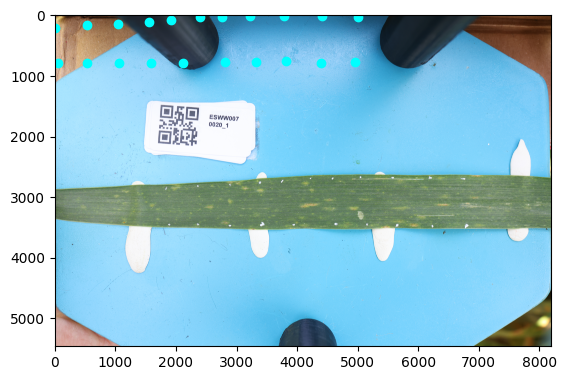

In [10]:
index = 4
# plt.figure(figsize=(12,6))
plt.imshow(available_data['images'][index])
plt.scatter(available_data['keypoints'][index][:,0], available_data['keypoints'][index][:,1], c='cyan' )
plt.show()

In [11]:
def keypoints_roi_to_image(kp_roi: np.ndarray, roi: dict):
    """
    kp_crop: (N,2) keypoints in crop coordinates (TXT)
    roi: dict with rotation_matrix (2x3) and bounding_box
    Returns: kp_full (N,2) in original image coordinates
    """
    kp_crop = kp_roi.astype(np.float64)

    # 1) shift by top-left of bounding box to get coordinates in rotated image
    box = np.asarray(roi["bounding_box"], dtype=np.float64)
    bbox_min = box.min(axis=0)  # [x_min, y_min]
    kp_rot_img = kp_crop + bbox_min  # coordinates in rotated image

    # 2) invert rotation to map back to original image
    R = np.asarray(roi["rotation_matrix"], dtype=np.float64)
    rot = R[:, :2]
    trans = R[:, 2:]
    rot_inv = np.linalg.inv(rot)
    kp_full = (kp_rot_img - trans.T) @ rot_inv.T

    return kp_full

kpts_img = keypoints_roi_to_image(available_data['keypoints'][index], available_data['rois'][index])

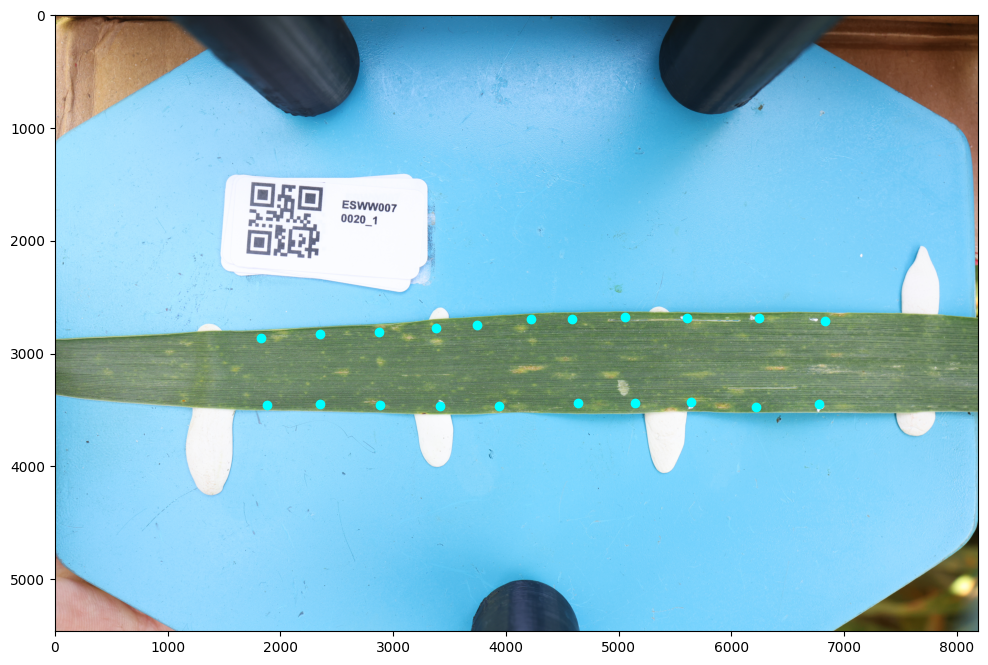

In [12]:
plt.figure(figsize=(16,8))
plt.imshow(available_data['images'][index])
plt.scatter(kpts_img[:,0], kpts_img[:,1], c='cyan' )
plt.show()

## Masking & Erosion

In [13]:
def pil_to_kornia(pil_img):
    np_img = np.array(pil_img)
    return K.image_to_tensor(np_img).float() / 255.0 

In [14]:
def mask_leaf(img: torch.Tensor, keypts: np.ndarray, erode_px: int = 0):
    img = pil_to_kornia(img)

    C,H,W = img.shape
    # Computes the convex hull of the keypoints.
    hull = cv2.convexHull(keypts.astype(np.int32)) # Returns ordered list of points forming a polygon that encloses all the keypoints.
    
    # initialize empty mask
    mask = np.zeros((H,W), dtype=np.uint8)
    cv2.fillConvexPoly(mask, hull.reshape(-1,2), 1) # fill in convex hull with value 1
    mask_t = torch.from_numpy(mask).float().to(img.device).unsqueeze(0) # convert mask to tensor and add channel dim
    if erode_px > 0:
        # FIXME
        print("erosion not yet functional")
        # kernel = torch.ones((erode_px,erode_px), dtype=torch.float32, device=mask_t.device)
        # mask_t = morph.erosion(mask_t.unsqueeze(0), kernel).squeeze(0)
    masked_img = img * mask_t
    return masked_img, mask_t

In [15]:
masked_img, mask_t = mask_leaf(available_data['images'][index], kpts_img, erode_px=0)

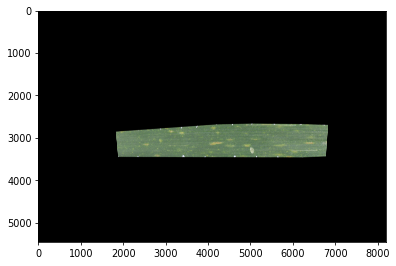

In [17]:
plt.figure(dpi=70)
plt.imshow(K.tensor_to_image(masked_img))
plt.show()

In [22]:
# img_scaled = K.geometry.transform.scale(masked_img, scale_factor=torch.tensor([[2, 2]], dtype=masked_img.dtype, device=masked_img.device))
# plt.imshow(K.tensor_to_image(img_scaled))
# plt.show()

In [ ]:
# H=256
# W=1024
# K.geometry.resize(masked_img, (H, W), antialias=True)

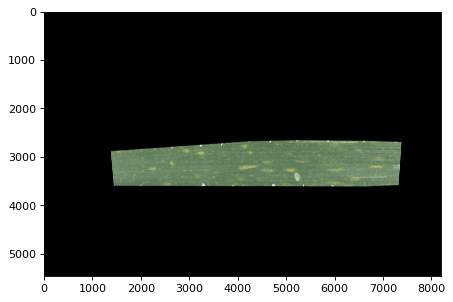

In [ ]:
def scale_image(img: torch.Tensor, scale: float):
    """
    img: (C,H,W) or (B,C,H,W) torch tensor
    scale: float >1 to enlarge
    """
    # Add batch dimension
    if img.dim() == 3:
        img = img.unsqueeze(0)  # (1,C,H,W)

    B,C,H,W = img.shape
    device = img.device
    dtype = img.dtype

    # Scale tensor: (B,2) float32 on same device
    scale_tensor = torch.tensor([[scale, scale]], dtype=dtype, device=device).repeat(B,1)

    # Center tensor: (B,2) float32 on same device
    # could choose custom center through which to scale, default is the center of the tensor
    # center = torch.tensor([[W/2, H/2]], dtype=dtype, device=device).repeat(B,1)

    # Apply scaling
    img_scaled = K.geometry.transform.scale(img, scale_factor=scale_tensor)

    # Remove batch dim if needed
    if img_scaled.shape[0] == 1:
        img_scaled = img_scaled.squeeze(0)

    return img_scaled

img_scaled = scale_image(masked_img, 1.2)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(img_scaled))
plt.show()

In [25]:
def erode_mask_by_scaling(mask: torch.Tensor, scale: float):
    """
    mask: (1,H,W) or (B,1,H,W) torch tensor
    scale: <1 to shrink the mask (simulate erosion)
    Returns: resized mask with same original image size
    """
    # Add batch dim if needed
    if mask.dim() == 3:
        mask = mask.unsqueeze(0)  # (1,1,H,W)

    B, C, H, W = mask.shape
    device = mask.device
    dtype = mask.dtype

    # Resize mask: shrink by scale factor
    new_H = int(H * scale)
    new_W = int(W * scale)
    mask_small = F.interpolate(mask, size=(new_H, new_W), mode='nearest')

    # Pad back to original size and center
    pad_top = (H - new_H) // 2
    pad_bottom = H - new_H - pad_top
    pad_left = (W - new_W) // 2
    pad_right = W - new_W - pad_left

    mask_eroded = F.pad(mask_small, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)

    # Remove batch dim if needed
    if mask_eroded.shape[0] == 1:
        mask_eroded = mask_eroded.squeeze(0)

    return mask_eroded
eroded_mask = erode_mask_by_scaling(mask_t, scale=0.9)

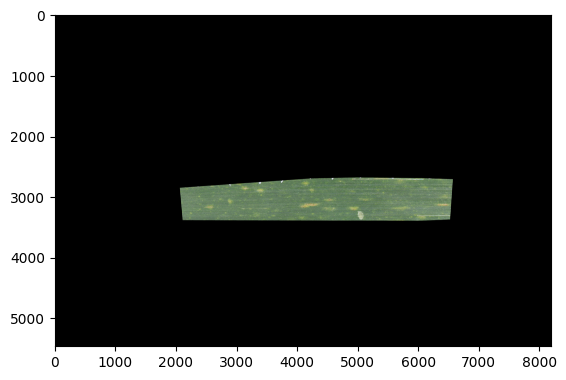

In [20]:
masked_scaled_img = masked_img * eroded_mask
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_scaled_img))
plt.show()

In [15]:
# masked_scaled_img = img_scaled * mask_t
# plt.imshow(K.tensor_to_image(masked_scaled_img))
# plt.show()

In [19]:
H=256
W=1024
moving_img = K.geometry.resize(masked_scaled_img, (H, W), antialias=True)
fixed_img = pil_to_kornia(available_data['images'][0])
fixed_img = K.geometry.resize(fixed_img, (H, W), antialias=True)

NameError: name 'masked_scaled_img' is not defined

## LoFTR

In [13]:
ind = 2 
img0 = available_data['images'][index]
img1 = available_data['images'][index+1]
keypts_img0 = keypoints_roi_to_image(img0, available_data['rois'][index])
keypts_img1 = keypoints_roi_to_image(img1, available_data['rois'][index+1])

In [14]:
masked_img0, mask_t0 = mask_leaf(img0, keypts_img0)
masked_img1, mask_t1 = mask_leaf(img1, keypts_img1)

In [15]:
eroded_mask0 = erode_mask_by_scaling(mask_t0, scale=0.9)
eroded_mask1 = erode_mask_by_scaling(mask_t1, scale=0.9)

In [16]:
masked_scaled_img0 = masked_img0 * eroded_mask0
masked_scaled_img1 = masked_img1 * eroded_mask1

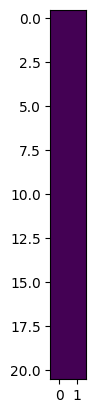

In [18]:
plt.imshow(K.tensor_to_image(masked_scaled_img1))
plt.show()